In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 6
n_nodes = 11
rate = 0.8
T = 50
dt = 0.5
fprefix = 'data/rrg_sis_'
train_sample = 31000
val_sample = 1000


In [3]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
#graph = nx.barabasi_albert_graph(n_nodes, 3)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the dataset
transform = [dl.SIS_StateToFloat()]
dataset = dl.SISDataset(rate)
dataset.generate(graph, train_sample, T, init_active=0.01, dt=dt, pre_transform=transform)

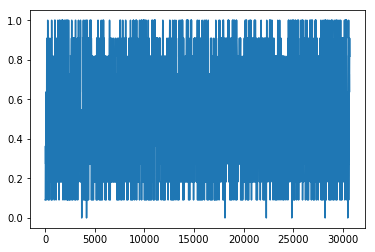

In [4]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [5]:
n_hidden = [128, 64]
n_embedding = n_nodes
keepprob = 0.9
lr = 1e-2
wd = 1e-3
optimizer = lambda p: torch.optim.Adam(p, lr=lr, weight_decay=wd)
loss = torch.nn.BCELoss(reduction='none')
use_cuda = torch.cuda.is_available()

model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding,
                                  keepprob=keepprob, optimizer=optimizer,
                                  use_cuda=use_cuda)

In [50]:
lr /= 2
for g in model.optimizer.param_groups:
    g['lr'] = lr
    

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])
model.fit(train_dataset,
          val_dataset=None,
          epochs=25,
          batch_size=128,
          verbose=True,
          keep_best=True,
          training_metrics=['loss', 'recon', 'kl_div'],
          model_metrics=['lr'],
          show_var=False,
          beta=1)

New best Epoch: 0 - Time: 0.00
	 Train. - loss: 972.5921, recon: 969.8093, kl_div: 2.7828, 
New best Epoch: 1 - Time: 3.80 - lr: 0.01
	 Train. - loss: 4.8357, recon: 3.0536, kl_div: 1.7821, 
New best Epoch: 2 - Time: 2.55 - lr: 0.01
	 Train. - loss: 2.2986, recon: 0.7034, kl_div: 1.5952, 
New best Epoch: 3 - Time: 2.67 - lr: 0.01
	 Train. - loss: 1.7272, recon: 0.3239, kl_div: 1.4033, 
Epoch: 4 - Time: 2.67 - lr: 0.01
New best Epoch: 5 - Time: 2.71 - lr: 0.01
	 Train. - loss: 1.7081, recon: 0.2480, kl_div: 1.4601, 
New best Epoch: 6 - Time: 2.65 - lr: 0.01
	 Train. - loss: 1.6021, recon: 0.5002, kl_div: 1.1019, 
New best Epoch: 7 - Time: 2.86 - lr: 0.01
	 Train. - loss: 1.5534, recon: 0.2575, kl_div: 1.2959, 
New best Epoch: 8 - Time: 3.27 - lr: 0.01
	 Train. - loss: 1.1134, recon: 0.1258, kl_div: 0.9877, 


In [52]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)
        states = states[0]
        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [57]:
null_model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding, keepprob=1, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(model, dataset)
untrained_ts = test_model(null_model, dataset)


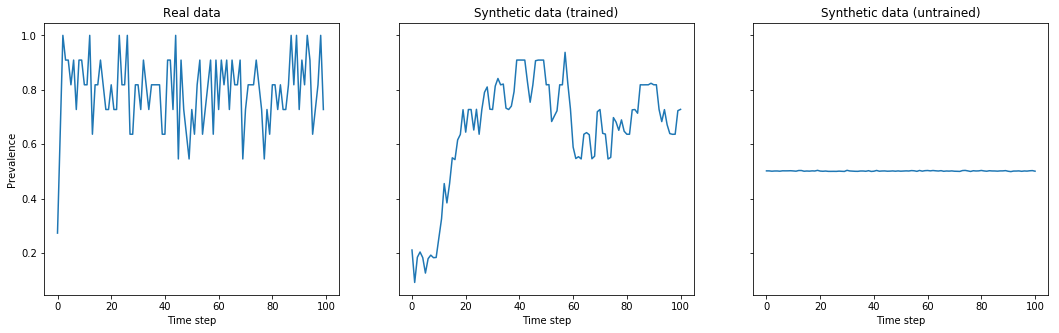

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

figname = "naivemodel_evol_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
#fig.savefig("fig/png/" + figname + ".png")
#fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()

In [59]:
def reconstruction_dataset(model, dataset, verbose=True):
    learned = np.zeros(len(dataset))
    real = np.zeros(len(dataset))
    
    for i, d in enumerate(dataset):
        
        if i%1000==0 and verbose: print(str(i) + "/" + str(len(dataset)))
        present, past = d
        sample, _, _ = model.predict(past, batch_size=2)
        learned[i] = np.mean(sample)
        real[i] = np.mean(present.numpy())
        
    return real, learned
        
    

In [23]:
real, learned = reconstruction_dataset(model, dataset, False)

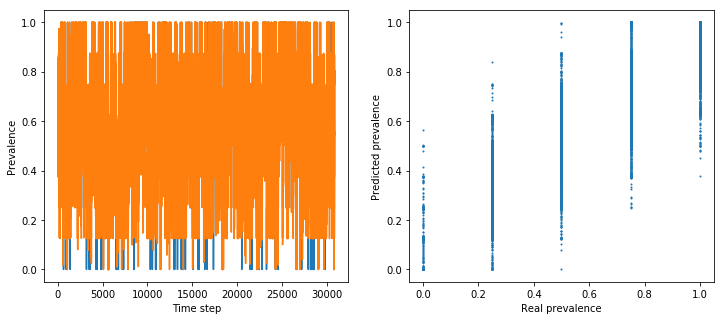

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real, '-')
ax[0].plot(learned, '-')
fig.savefig(figname + ".png")
fig.savefig(figname + ".pdf")
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')

ax[1].plot(real, learned, '.', markersize=2)
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Predicted prevalence')

figname = "naivemodel_recon_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
#fig.savefig("fig/png/" + figname + ".png")
#fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()

In [60]:
def reconstruct_TS(graph, model, dataset, T, dt):
    transform = [dl.SIS_StateToFloat()]
    t = 0
    past = dataset.init_state(graph, 0.01, pre_transform=transform)
    real_ts = []
    learned_ts = []
    while(t < T):
        t += dt
        real_prob = dataset.get_transition_probability(graph, past, dt)
        real_ts.append(real_prob)
        
        learned_prob = np.mean(model.predict(past, batch_size=128), 0)
        learned_ts.append(learned_prob)
        past = torch.bernoulli(torch.tensor(real_prob))
    
    return real_prob, learned_prob
        
        
        


In [23]:
all_states = dataset.enumerate_all_states(graph)
markovProb = np.zeros([len(all_states), len(all_states)])

for i, past in enumerate(all_states):
    prob = dataset.get_transition_probability(graph, past, dt)
    for j, present in enumerate(all_states):
        present_prob = present * prob + (1 - present) * (1 - prob)
        markovProb[i, j] = np.prod(present_prob)
# markovProb = np.log(markovProb)

In [24]:
learnedProb = np.zeros([len(all_states), len(all_states)])
for i, past in enumerate(all_states):
    _past = torch.tensor(past).float()
    prob, _, _ = model.predict(_past, batch_size=1024)
    avg_prob = np.mean(prob, 0)
    for j, present in enumerate(all_states):
        present_prob = present * avg_prob + (1 - present) * (1 - avg_prob)
        learnedProb[i, j] = np.prod(present_prob)
# learnedProb = np.log(learnedProb)

In [25]:
print(np.min(markovProb), np.min(learnedProb))
print(np.max(markovProb), np.max(learnedProb))

0.0 2.8767314513550874e-15
1.0 0.5790480943193517


/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


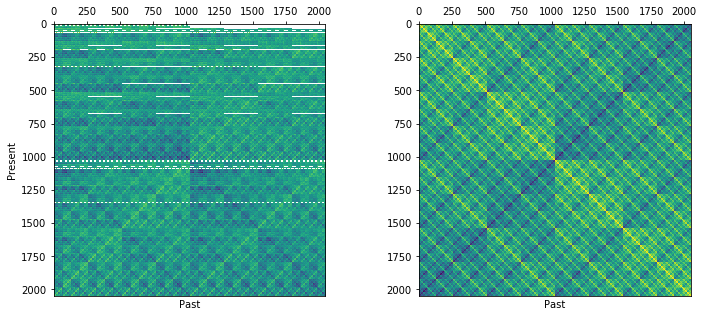

In [32]:
from matplotlib.colors import LogNorm

# fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# x = np.log(markovProb)
x = markovProb / np.sum(markovProb, 0)
# x = np.log(x)
cs = ax[0].imshow(np.log(x), origin='upper')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')

# x = np.log(learnedProb)
x = learnedProb / np.sum(learnedProb, 0)
x = np.log(x)
ax[1].imshow(x, origin='upper')
ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')

figname = "naivemodel_trans_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
# fig.savefig("fig/png/" + figname + ".png")
# fig.savefig("fig/pdf/" + figname + ".pdf")

plt.show()

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


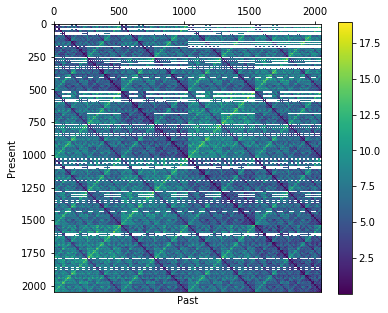

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

x1 = np.log(markovProb / np.sum(markovProb, 0))
x2 = np.log(learnedProb / np.sum(learnedProb, 0))

cs = ax.imshow(abs(x2 - x1), origin='upper')
ax.xaxis.tick_top()
ax.set_xlabel('Past')
ax.set_ylabel('Present')

plt.colorbar(cs)
plt.show()

In [65]:
realTransitionProb = np.array([])
for s in dataset:
    past = s[1].numpy()
    realTransitionProb = np.append(realTransitionProb, dataset.get_transition_probability(graph, past, dt))

learnedTransitionProb = np.array([[]])
for s in dataset:
    past = s[1]
    prob, _, _ = model.predict(past, batch_size=128)
#     print(prob)
    prob = np.mean(prob, 0)
    learnedTransitionProb = np.append(learnedTransitionProb, prob)

In [ ]:
dataset[0]

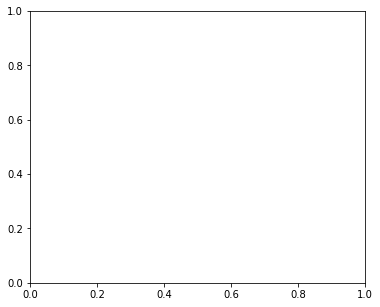

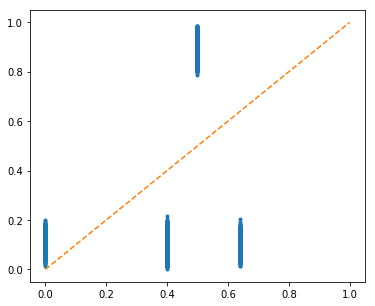

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(realTransitionProb, learnedTransitionProb, '.')
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
plt.show()